In [1]:
from tqdm import tqdm
import numpy as np
from pickle import dump
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline

def read_tweet(f_desc):
    ans = dict()
    ans['username'] = f_desc.readline()
    ans['tweet_id'] = f_desc.readline()
    hours, minutes, seconds = map(int, f_desc.readline().split()[3].split(':'))
    ans['time'] = hours / 24 + minutes / (60 * 24) + seconds / (60 * 60 * 24)
    ans['user_app'] = f_desc.readline()
    ans['is_retweet'] = (f_desc.readline() == '-1\n')
    ans['is_reply'] = (int(len(f_desc.readline().split('\t'))) == 2)
    ans['content_len'] = len(list(map(int, f_desc.readline().split())))
    ans['n_links'] = int(f_desc.readline())
    for i in range(ans['n_links']):
        f_desc.readline()
    f_desc.readline() # blank line
    return ans


def update(val, tweet):
    val['time_hist'][floor(T_HIST_LEN * tweet['time'])] += 1
    val['n_tweets'] += 1
    if tweet['is_retweet'] >= 0:
        val['n_retweets'] += 1
    if tweet['is_reply']:
        val['n_replies'] += 1
    val['content_len'] += tweet['content_len']
    val['n_links'] += tweet['n_links']
    return val


def default_val():
    val = dict()
    val['time_hist'] = np.zeros(T_HIST_LEN)
    val['n_tweets'] = 0
    val['n_retweets'] = 0
    val['n_replies'] = 0
    val['content_len'] = 0
    val['n_links'] = 0
    return val

    
def some_tweets(path='../datasets/tweet_result_0_.txt', n_tweets=1000):
    f_desc = open(path)
    ans = []
    for i in range(n_tweets):
        try:
            ans.append(read_tweet(f_desc))                
        except:
            # end of file
            break
    return ans


def parse_tweets(path='../datasets/tweet_result_0_.txt', tw_limit=10**18):
    f_desc = open(path)
    ans = dict()
    for i in range(tw_limit): # переписать
        try:
            tweet = read_tweet(f_desc)
            username = tweet['username']
            if username not in ans:
                ans[username] = default_val()
            ans[username] = update(ans[username], tweet)
        except:
            break
    return ans

In [ ]:
from time import time

for i in range(0, 20):
    print(i)
    t_begin = time()
    parsed = parse_tweets('../datasets/twitter_dataset/tweet_result_%d_.txt' % i)
    dump(parsed, open('../tmp_files/tw_parsed_%d.pickle' % i, "wb"))
    print(time() - t_begin)

In [ ]:
%%time

from pickle import load

def merge(d_merged, d_new):
    for i in d_new:
        if i in d_merged:
            for j in d_new[i]:
                d_merged[i][j] += d_new[i][j]
        else:
            d_merged[i] = d_new[i]
    return d_merged

template = '../tmp_files/tw_parsed_%d.pickle'
merged = load(open(template % 0, "rb"))
for i in range(1, 20):
    merged = merge(merged, load(open(template % i, "rb")))
dump(merged, open("../tmp_files/tw_parsed_merged", "wb"))

In [7]:
from pickle import load
merged = load(open('../tmp_files/tw_parsed_merged', "rb"))
good_names = set(i.split()[1] + "\n" for i in open("../datasets/twitter_dataset/user_map.txt"))
bad_keys = [i for i in merged.keys() if i not in good_names]
for key in bad_keys:
    merged.pop(key)
dump(merged, open("../tmp_files/tw_parsed_merged_pruned", "wb"))
merged_keys = sorted(list(merged.keys()))
dump(merged_keys, open("../tmp_files/tw_merged_keys", "wb"))

In [8]:
ROW_LEN = 8
cols_std = (1, 1, 1, 1, 0.25, 0.25, 0.25, 0.25)

def to_row(val):
    ans = np.zeros(ROW_LEN)
    ans[0] = val['content_len'] / val['n_tweets']
    ans[1] = val['n_links'] / val['n_tweets']
    ans[2] = val['n_replies'] / val['n_tweets']
    ans[3] = val['n_tweets']
    ans[4:8] = val['time_hist']
    return ans
    
matrix = np.zeros((len(merged_keys), ROW_LEN))
for num_row, i in enumerate(merged_keys):
    matrix[num_row] = to_row(merged[i])
for i, std in enumerate(cols_std):
    matrix[:, i] /= matrix[:, i].std()
    matrix[:, i] *= std

matrix += np.random.randn(matrix.shape) * 1e-4
with open("../datasets/tw_mat0", "w") as f:
    for row in matrix:
        for elem in row:
            print("%.8f" % elem, end=' ', file=f)
        print(file=f)

(array([6.9034e+04, 1.9270e+04, 1.5110e+03, 2.6800e+02, 9.0000e+01,
        6.4000e+01, 1.9000e+01, 1.5000e+01, 1.0000e+01, 1.0000e+01]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

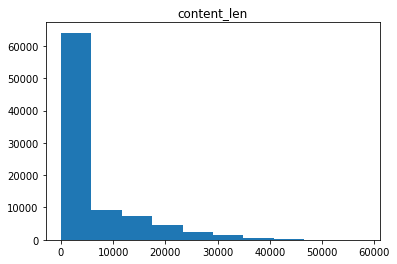

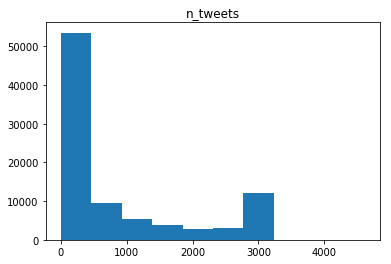

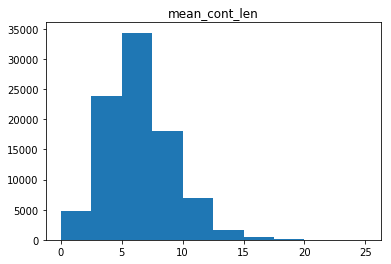

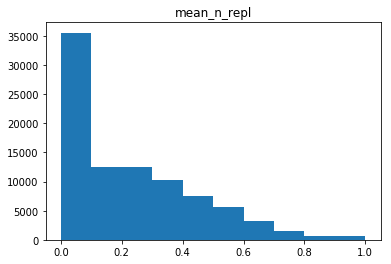

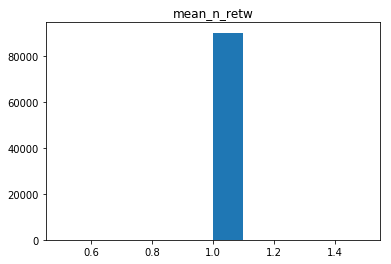

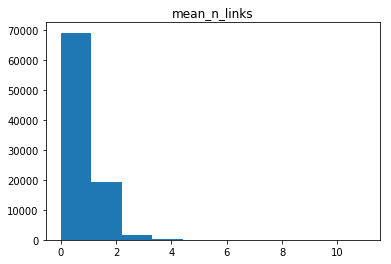

In [29]:
plt.title("content_len")
plt.hist([i['content_len'] for i in merged.values()])
plt.figure()

plt.title("n_tweets")
plt.hist([i['n_tweets'] for i in merged.values()])
plt.figure()

plt.title("mean_cont_len")
plt.hist([i['content_len'] / max(1, i['n_tweets']) for i in merged.values()])
plt.figure()

plt.title("mean_n_repl")
plt.hist([i['n_replies'] / max(1, i['n_tweets']) for i in merged.values()])
plt.figure()

plt.title("mean_n_retw")
plt.hist([i['n_retweets'] / max(1, i['n_tweets']) for i in merged.values()])
plt.figure()

plt.title("mean_n_links")
plt.hist([i['n_links'] / max(1, i['n_tweets']) for i in merged.values()])

In [6]:
! wc ../datasets/twitter_dataset/user_list.txt ../datasets/twitter_dataset/user_map.txt

 112416  112416 1150880 ../datasets/twitter_dataset/user_list.txt
 112449  224898 2472989 ../datasets/twitter_dataset/user_map.txt
 224865  337314 3623869 total


In [7]:
! tail -n 5 ../datasets/twitter_dataset/user_map.txt